In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import pickle

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential #, Input
from tensorflow.keras.layers import *
# from keras.layers import Attention
from tensorflow.keras.optimizers import *
import matplotlib.pyplot as plt
from livelossplot.tf_keras import PlotLossesCallback
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn import decomposition
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import KFold, StratifiedKFold

from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns

from sklearn.model_selection import KFold, cross_val_score
%matplotlib inline
# %matplotlib notebook

# 1. Load Data and Pre-process

## [Case 1] Averaged data input

In [2]:
#load data
def load_data(datafile):
    df = pd.read_csv(datafile)
    df = df.drop(df.columns[0], axis=1)
    return df

#Split features and label
def split_label(df):
    df = np.array(df)
    Y = df[:,-1]
    print('Y original =', Y)
    Y = np.where(Y==1, 0, Y) #combine label 0 and 1
    Y = np.where(Y==2, 1, Y) #change label 2 to 1
    Y = np.where(Y==3, 2, Y) #change label 3 to 2
    print('Y before encode =', Y)
    Y = LabelEncoder().fit_transform(Y) #encode label value as label variable
#     Y = [[x] for x in Y]
#     Y = np.array(Y)
    print('Y after encode =', Y)
    X = df[:,0:-1]    
    return X, Y

#Resampling
def resample(label0,label1,label2,X,Y):
    #downsampling
    strategydown = {0:label0, 1:label1, 2:label2} 
    downsample = RandomUnderSampler(sampling_strategy=strategydown) 
    X_resampled, Y_resampled = downsample.fit_resample(X, Y) #fit and apply transform
    
    #oversampling
    oversample = SMOTE()#sampling_strategy='not minority'
    X_resampled, Y_resampled = oversample.fit_resample(X_resampled, Y_resampled) #fit and apply transform
    return X_resampled, Y_resampled 

# Normalization and dimensionality reduction
def norm(X):     
#     #feature selection
#     selector = SelectKBest(f_classif, k=200)
#     X = selector.fit_transform(X, Y)
    #print(selected_features)

    # normalize the range features
    scaler = MinMaxScaler(feature_range=(0,1))  #.fit(X_train_av)
    X = scaler.fit_transform(X)
    #X_inverted = scaler.inverse_transform(X)

    # PCA decomposition. Set components number from 329(original) to 200
    pca = decomposition.PCA(n_components=250) #.fit(X_train_av)
    X = pca.fit_transform(X)
    
    return X #, X_inverted

#reshape to 3D data (nsample,ntimestep,nfeatures)
def reshaping(X):
    X = X.reshape(X.shape[0],1,X.shape[1]) 
    return X

In [3]:
df_train_av = load_data('daisee_openface/average_train.csv')
df_val_av = load_data('daisee_openface/average_val.csv')
df_test_av = load_data('daisee_openface/average_test.csv')
print('Train = ', df_train_av.shape)
print('Val = ', df_val_av.shape)
print('Test = ', df_test_av.shape)

Train =  (5358, 330)
Val =  (1429, 330)
Test =  (1784, 330)


In [4]:
#Concatenate train and validation set
df_train_concat = pd.concat([df_train_av,df_val_av], axis=0, ignore_index=True)
df_all_concat = pd.concat([df_train_concat,df_test_av], axis=0, ignore_index=True)
print(df_all_concat.shape)
print(df_train_concat.shape)

(8571, 330)
(6787, 330)


In [5]:
X_train_all, Y_train_all = split_label(df_all_concat)
X_train_av, Y_train_av = split_label(df_train_concat)
# X_train_av, Y_train_av = split_label(df_train_av)
X_val_av, Y_val_av = split_label(df_val_av)
X_test_av, Y_test_av = split_label(df_test_av)

Y original = [2. 2. 3. ... 3. 3. 2.]
Y before encode = [1. 1. 2. ... 2. 2. 1.]
Y after encode = [1 1 2 ... 2 2 1]
Y original = [2. 2. 3. ... 2. 2. 2.]
Y before encode = [1. 1. 2. ... 1. 1. 1.]
Y after encode = [1 1 2 ... 1 1 1]
Y original = [2. 3. 2. ... 2. 2. 2.]
Y before encode = [1. 2. 1. ... 1. 1. 1.]
Y after encode = [1 2 1 ... 1 1 1]
Y original = [2. 2. 2. ... 3. 3. 2.]
Y before encode = [1. 1. 1. ... 2. 2. 1.]
Y after encode = [1 1 1 ... 2 2 1]


Train + Validation set:
Engagement=1, n=3430 (50.538%)
Engagement=2, n=2944 (43.377%)
Engagement=0, n=413 (6.085%)
Total= 6787

Validation-only set:
Engagement=1, n=813 (56.893%)
Engagement=2, n=450 (31.491%)
Engagement=0, n=166 (11.617%)
Total= 1429

Test set:
Engagement=1, n=882 (49.439%)
Engagement=2, n=814 (45.628%)
Engagement=0, n=88 (4.933%)
Total= 1784
[1, 2, 0]
[3430, 2944, 413]


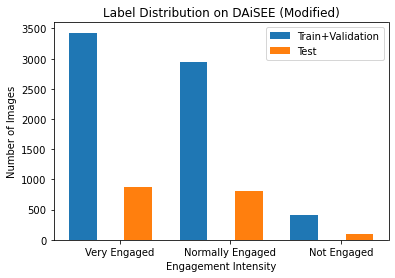

In [6]:
#Plot Distribution after concatenation train+validation
def plot_dist(Y):
    counter = Counter(Y)
    key =[]
    value = []
    for k,v in counter.items():
        per = v / len(Y)*100
        print('Engagement=%d, n=%d (%.3f%%)' % (k,v,per))
        key.append(k)
        value.append(v)
    print('Total=', len(Y))
    return key, value

print("Train + Validation set:")
k_train, v_train = plot_dist(Y_train_av)
print("\nValidation-only set:")
k_val, v_val = plot_dist(Y_val_av)
print("\nTest set:")
k_test, v_test = plot_dist(Y_test_av)
print(k_train)
print(v_train)

#Plot the distribution
ind = np.arange(len(k_train)) 
w = 0.25 
plt.bar(ind  , v_train, width=w, label='Train+Validation')
# plt.bar(ind + w, v_val, width=w, label='Validation')
plt.bar(ind + w + w, v_test, width=w,label='Test')

plt.ylabel('Number of Images')
plt.xlabel('Engagement Intensity')
plt.title('Label Distribution on DAiSEE (Modified)')
plt.xticks(ind + w + w/ 3, ('Very Engaged','Normally Engaged','Not Engaged'))

# plt.title('Engagement Label Distributions on DAiSEE')
# plt.xticks(ind + 0.08 + 0.08 + 0.08, ('3\nVery High','2\nHigh','1\nLow','0\nVery Low'))
plt.legend(loc='best')
plt.show()

In [7]:
X_train_all, Y_train_all = resample(501,2000,2000,X_train_all,Y_train_all) #413,1472,1715
X_train_av, Y_train_av = resample(413,1000,1000,X_train_av,Y_train_av) #247,1000,1000
X_val_av, Y_val_av = resample(166,200,200,X_val_av,Y_val_av)
X_test_av, Y_test_av = resample(88,441,407,X_test_av,Y_test_av)

In [8]:
X_train_all = norm(X_train_all)
X_train = norm(X_train_av)
X_val_av = norm(X_val_av)
X_test_av = norm(X_test_av)
# print('X training=',X_train.shape)
# # print('X val=',X_val.shape)
# print('X test=',X_test.shape)
X_train_av = X_train

In [9]:
X_train_all = reshaping(X_train_all)
X_train_av = reshaping(X_train_av)
X_val_av = reshaping(X_val_av)
X_test_av = reshaping(X_test_av) 
print('X_train_all:{} | Y_train_all:{}\nX_train_av:{} | Y_train_av:{}\nX_test_av:{} | Y_test_av:{} '.format(X_train_all.shape, Y_train_all.shape, X_train_av.shape, Y_train_av.shape, X_test_av.shape, Y_test_av.shape))


X_train_all:(6000, 1, 250) | Y_train_all:(6000,)
X_train_av:(3000, 1, 250) | Y_train_av:(3000,)
X_test_av:(1323, 1, 250) | Y_test_av:(1323,) 


In [10]:
Y_train_cat_all = to_categorical(Y_train_all)
Y_train_cat_av = to_categorical(Y_train_av) #convert label vector to one-hot matrix
Y_val_cat_av = to_categorical(Y_val_av) #convert label vector to one-hot matrix
Y_test_cat_av = to_categorical(Y_test_av) 
print('Y after convert to 1hot =', Y_train_cat_av)
print(Y_train_cat_av.shape)

Y after convert to 1hot = [[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
(3000, 3)


In [46]:
Y_test_cat_av = to_categorical(Y_test_av)

## [Case 2] Non averaged data input

In [11]:
path = ('C:/Users/hasegawa-lab-pc/OneDrive - Japan Advanced Institute of Science and Technology/Documents/Dataset/DAiSEE/OpenFace_2.2.0_win_x64/processed/csv/')

def load_all_data(datapath,labelfile):
    #load label
    df = pd.read_csv(labelfile)
    
    #create empty list
    data_list = []
    label_list = []
    
    for noid, clipid in enumerate(df.ClipID):
        temp_df = pd.read_csv(datapath+clipid, nrows=300) #read csv files (n timestamps)
        temp_df = temp_df.drop(temp_df.columns[0:5], axis=1) #drop first 5 columns 
        # temp_df = temp_df.iloc[9:300:21,:] #take 1 every 21 frame   
        temp_df = temp_df.groupby(np.arange(len(temp_df))//30).mean() #average every 30 frames, resulting 10 timesteps

        # ensure all data is float
        temp_df = temp_df.astype('float32')
              
        # PCA decomposition. Set components number from 329(original) to 200
        #     pca = decomposition.PCA(n_components=250)
        #     temp_df = pca.fit_transform(temp_df)
        #     print(temp_df)
        
        temp_df = np.array(temp_df, dtype=object)
        labl = df.Engagement[noid]
        labl = np.array(labl)
        #     print(temp_df,labl)
        data_list.append(temp_df)
        label_list.append(labl)    
#         break
    
    X = np.array(data_list, dtype=object) #features
    Y = np.array(label_list) #labels
    print('X shape:{} | Y shape:{}'.format(X.shape, Y.shape))
    
    return X, Y

In [ ]:
tic = datetime.now()
X_train_all, Y_train_all = load_all_data(path+'csv_train/',path+'labels/TrainLabels.csv')
X_val_all, Y_val_all = load_all_data(path+'csv_val/',path+'labels/ValidationLabels.csv')
X_test_all, Y_test_all = load_all_data(path+'csv_test/',path+'labels/TestLabels.csv')

time = datetime.now() - tic
print('Processing time {}'.format(time))

In [ ]:
tic = datetime.now()

scaler = MinMaxScaler(feature_range=(0,1))
X_train_all_scalled = scaler.fit_transform(X_train_all.reshape(-1, X_train_all.shape[-1])).reshape(X_train_all.shape)

X_val_all_scalled = scaler.transform(X_val_all.reshape(-1, X_val_all.shape[-1])).reshape(X_val_all.shape)

X_test_all_scalled = scaler.transform(X_test_all.reshape(-1, X_test_all.shape[-1])).reshape(X_test_all.shape)

time = datetime.now() - tic
print('Processing time {}'.format(time))
print(X_train_all_scalled.shape,X_val_all_scalled.shape,X_test_all_scalled.shape)

In [ ]:
# tic = datetime.now()

# pca = decomposition.PCA(n_components=250)
# X_train_all_scalled = pca.fit_transform(X_train_all_scalled.reshape(-1, X_train_all_scalled.shape[-1])).reshape(X_train_all_scalled.shape)

# X_val_all_scalled = pca.transform(X_val_all_scalled.reshape(-1, X_val_all_scalled.shape[-1])).reshape(X_val_all_scalled.shape)

# X_test_all_scalled = pca.transform(X_test_all_scalled.reshape(-1, X_test_all_scalled.shape[-1])).reshape(X_test_all_scalled.shape)

# time = datetime.now() - tic
# print('Processing time {}'.format(time))

In [ ]:
with open('C:/Users/hasegawa-lab-pc/OneDrive - Japan Advanced Institute of Science and Technology/Documents/Exp_Shofi/Statistical Analysis/extracted/daisee_329dims_10timesteps.pkl','wb') as f:
    pickle.dump([X_train_all, X_val_all, X_test_all, X_train_all_scalled, X_val_all_scalled, X_test_all_scalled, Y_train_all, Y_val_all, Y_test_all], f)

In [ ]:
#modify label
def modif_label(Y):
    Y = np.where(Y==1, 0, Y) #combine label 0 and 1
    Y = np.where(Y==2, 1, Y) #change label 2 to 1
    Y = np.where(Y==3, 2, Y) #change label 3 to 2
    print('Y before encode =', Y)
    print('Shape before encode =', Y.shape)
    Y = LabelEncoder().fit_transform(Y) #encode label value as label variable
    print('Y after encode =', Y)
    print('Shape after encode =', Y.shape)
#     print('Shape before cat =', Y.shape)
#     Y_cat = to_categorical(Y)
#     print('Shape after cat =', Y.shape)
    return Y#, Y_cat

In [ ]:
Y_train_modif = modif_label(Y_train) #, Y_train_modif_cat

In [ ]:
Y_train_cat = to_categorical(Y_train_modif)
print(Y_train_cat)
print(Y_train_cat.shape)

In [ ]:
Y_val_modif = modif_label(Y_val)

In [ ]:
Y_val_cat = to_categorical(Y_val_modif)
print(Y_val_cat)
print(Y_val_cat.shape)

# 2. Build Models, Compile and Train

In [11]:
# Models
# ## 1. Vanila LSTM
# - Memory cells of a single LSTM layer are used in a simple network structure
def vanilaLSTM(X):
    model = Sequential()
    model.add(LSTM(50, input_shape=(X.shape[1],X.shape[2]))) #use average data
    model.add(Dense(3, activation='softmax'))
    model._name='vanilaLSTM'
    print(model.summary())
    return model

# ## 2. Stacked LSTM
# - LSTM layers are stacked one on top of another into deep recurrent neural networks
def stackedLSTM(X):
    model = Sequential()
    model.add(LSTM(75, activation='relu', return_sequences=True, input_shape=(X.shape[1],X.shape[2])))
    model.add(LSTM(75, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model._name='stackedLSTM'
    print(model.summary())
    return model

# ## 3. Bi-LSTM
# - Input sequences are presented and learned both forward and backward
def biLSTM(X):
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(X.shape[1],X.shape[2])))
    model.add(Dense(3, activation='softmax'))
    model._name='biLSTM'
    print(model.summary())
    return model

# ## 4. BiLSTM (Ensamble)
# - Follow An Ensemble model using face and body tracking for engagement detection
def bilstm_en(X):
    model = Sequential()
    model.add(InputLayer(input_shape=((X.shape[1],X.shape[2]))))
    model.add(Dense(16))
    model.add(BatchNormalization())
    # model.add(Dropout(0.2))
    model.add(Activation('relu'))
    # model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(50)))
    # model.add(Dropout(0.5))
    # modelD.add(GlobalAveragePooling1D())
    model.add(Dense(16))
    model.add(Activation('relu'))
    model.add(Dense(3, activation='softmax'))
    model._name='bilstm_en'
    print(model.summary())
    return model

In [12]:
#instantiate the model[Case 1]
vanilaLSTM_model = vanilaLSTM(X_train_av)
stackedLSTM_model = stackedLSTM(X_train_av)
biLSTM_model = biLSTM(X_train_av)
bilstm_en_model = bilstm_en(X_train_av)

Model: "vanilaLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                60200     
_________________________________________________________________
dense (Dense)                (None, 3)                 153       
Total params: 60,353
Trainable params: 60,353
Non-trainable params: 0
_________________________________________________________________
None
Model: "stackedLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 75)             97800     
_________________________________________________________________
lstm_2 (LSTM)                (None, 75)                45300     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 228       
Total params: 143,328
Trai

In [72]:
# #instantiate the model [Case 2]
# vanilaLSTM_model = vanilaLSTM(X_train)
# stackedLSTM_model = stackedLSTM(X_train)
# biLSTM_model = biLSTM(X_train)
# bilstm_en_model = bilstm_en(X_train)

### Training and Compile

In [39]:
#compile and train model
def compile_train(model,Xtrain,YtrainCat):
    loss = 'categorical_crossentropy' # mse 'sparse_categorical_crossentropy'
    metrics = ['categorical_accuracy'] 
    monitor= 'categorical_accuracy' 
    lr=1e-3

    #learning rate schedule: reduce learning rate 0.1 every 2 epochs 
    reduce_lr = ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=2, min_lr=0.00001, mode='auto')
    es = EarlyStopping(monitor=monitor, min_delta=0.0001, patience=50)

    model.compile(loss=loss, optimizer=Adam(lr=lr), metrics=metrics)  
    filepath = 'weights/' + model.name + '.hdf5'
    checkpoint = ModelCheckpoint(filepath, monitor=monitor, verbose=1,
                                 save_weights_only=True, save_best_only=True,
                                 mode='auto')
    history = model.fit(Xtrain,YtrainCat, epochs=500, verbose=1,
                        callbacks = [PlotLossesCallback(), checkpoint, es],# ,reduce_lr
                        batch_size = 32,
                        validation_split=0.2, 
                        # validation_data=(X_test_av, Y_test_cat_av), 
                        # validation_data=(X_val_av, Y_val_cat_av), 
                        shuffle=True
                        # class_weight = 'balanced'
                       )
    
    weight_file = model.save(filepath)
    # mse, acc = model.evaluate(X_train, YtrainCat, verbose=0)
    return history, weight_file

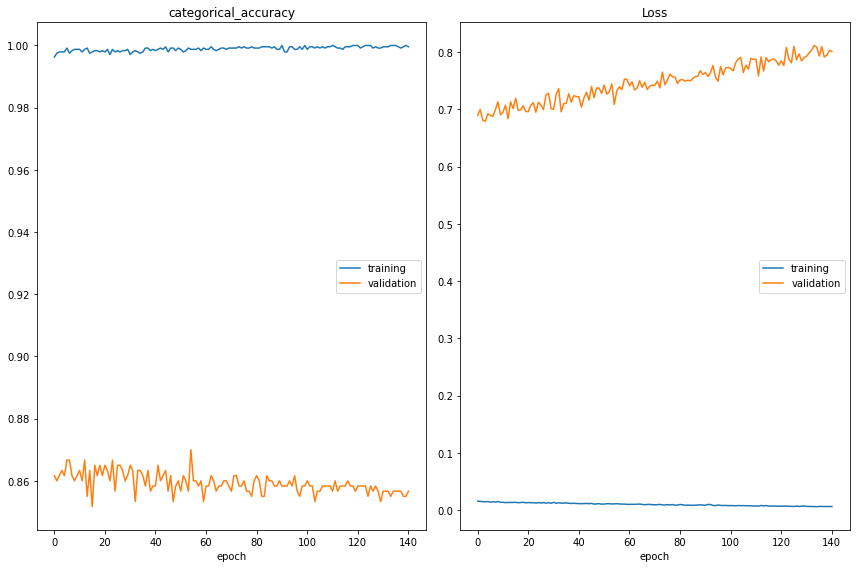

categorical_accuracy
	training         	 (min:    0.996, max:    1.000, cur:    1.000)
	validation       	 (min:    0.852, max:    0.870, cur:    0.857)
Loss
	training         	 (min:    0.006, max:    0.016, cur:    0.006)
	validation       	 (min:    0.679, max:    0.812, cur:    0.801)

Epoch 00141: categorical_accuracy did not improve from 1.00000
2400/2400 [==============================] - 0s 161us/sample - loss: 0.0060 - categorical_accuracy: 0.9996 - val_loss: 0.8014 - val_categorical_accuracy: 0.8567


(<tensorflow.python.keras.callbacks.History at 0x19501e68b00>, None)

In [40]:
compile_train(vanilaLSTM_model,X_train_av,Y_train_cat_av)  # [case 1] classification
# compile_train(vanilaLSTM_model,X_train_av,Y_train_av)  # [case 1] regression
# compile_train(vanilaLSTM_model,X_train,Y_train_cat)  # [case 2]

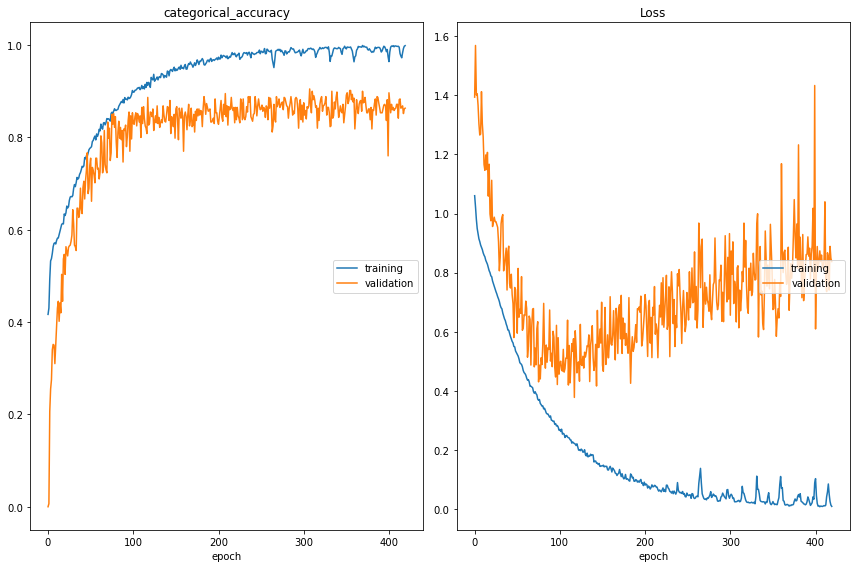

categorical_accuracy
	training         	 (min:    0.417, max:    0.999, cur:    0.999)
	validation       	 (min:    0.000, max:    0.905, cur:    0.863)
Loss
	training         	 (min:    0.009, max:    1.060, cur:    0.010)
	validation       	 (min:    0.378, max:    1.568, cur:    0.838)

Epoch 00420: categorical_accuracy did not improve from 0.99917
2400/2400 [==============================] - 0s 178us/sample - loss: 0.0100 - categorical_accuracy: 0.9987 - val_loss: 0.8377 - val_categorical_accuracy: 0.8633


(<tensorflow.python.keras.callbacks.History at 0x19510f202b0>, None)

In [41]:
compile_train(stackedLSTM_model,X_train_av,Y_train_cat_av)  # [case 1] Classification
# compile_train(stackedLSTM_model,X_train_av,Y_train_av)  # [case 1] Regression
# compile_train(stackedLSTM_model,X_train,Y_train_cat)  # [case 2]

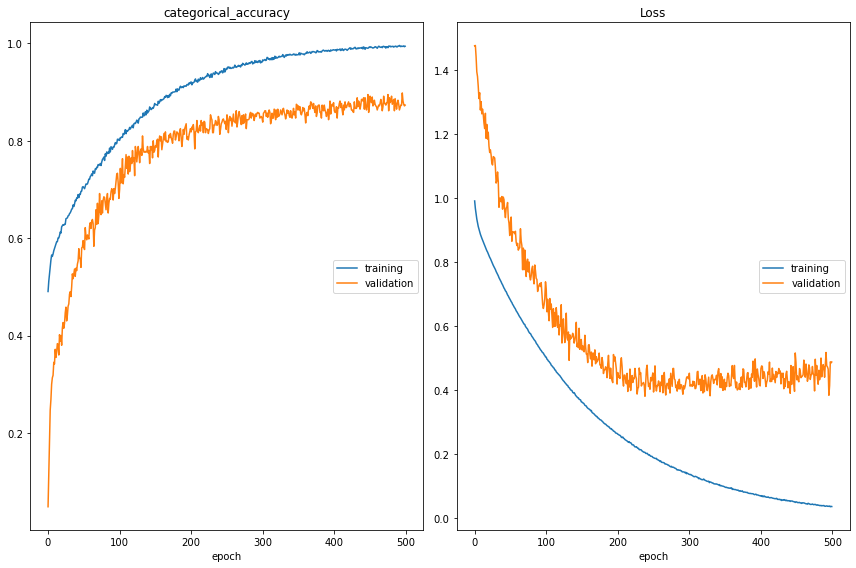

categorical_accuracy
	training         	 (min:    0.490, max:    0.996, cur:    0.994)
	validation       	 (min:    0.048, max:    0.898, cur:    0.873)
Loss
	training         	 (min:    0.036, max:    0.992, cur:    0.037)
	validation       	 (min:    0.382, max:    1.478, cur:    0.489)

Epoch 00500: categorical_accuracy did not improve from 0.99583
2400/2400 [==============================] - 0s 179us/sample - loss: 0.0370 - categorical_accuracy: 0.9942 - val_loss: 0.4888 - val_categorical_accuracy: 0.8733


(<tensorflow.python.keras.callbacks.History at 0x19553e21668>, None)

In [42]:
compile_train(biLSTM_model,X_train_av,Y_train_cat_av)  # [case 1] Classification
# compile_train(biLSTM_model,X_train_av,Y_train_av)  # [case 1] Regression
# compile_train(biLSTM_model,X_train,Y_train_cat)  # [case 2]

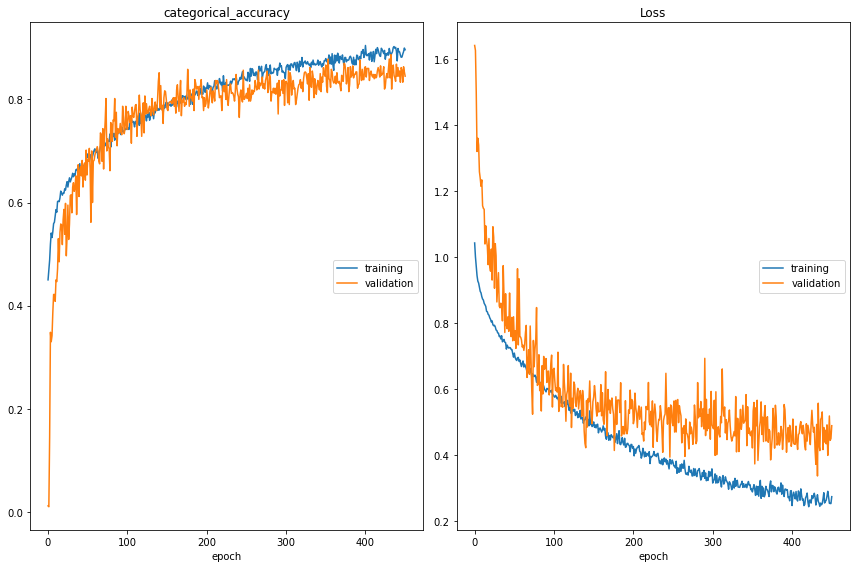

categorical_accuracy
	training         	 (min:    0.450, max:    0.905, cur:    0.896)
	validation       	 (min:    0.010, max:    0.887, cur:    0.845)
Loss
	training         	 (min:    0.244, max:    1.043, cur:    0.274)
	validation       	 (min:    0.337, max:    1.642, cur:    0.489)

Epoch 00451: categorical_accuracy did not improve from 0.90458
2400/2400 [==============================] - 1s 222us/sample - loss: 0.2740 - categorical_accuracy: 0.8963 - val_loss: 0.4892 - val_categorical_accuracy: 0.8450


(<tensorflow.python.keras.callbacks.History at 0x19554310128>, None)

In [43]:
compile_train(bilstm_en_model,X_train_av,Y_train_cat_av)  # [case 1] Classification
# compile_train(bilstm_en_model,X_train_av,Y_train_av)  # [case 1] Regression
# compile_train(bilstm_en_model,X_train,Y_train_cat)  # [case 2]

## K-Fold Cross Validation

In [18]:
save_dir = '/weights/'
fold_var = 1
#KFold split
kf = KFold(n_splits = 5)
skf = StratifiedKFold(n_splits = 5, random_state = None, shuffle = False)
cvscores_single = []

In [19]:
kf = KFold(n_splits = 5)
skf = StratifiedKFold(n_splits = 5, random_state = None, shuffle = True)
cvscores = []
# for train_index, val_index in enumerate(kf.split(X_train_av,Y_train_cat_av)):
for train_index, val_index in kf.split(X_train_all,Y_train_all):
    # print("TRAIN:", train_index, "TEST:", val_index)
    # X_train, X_test = X_train_all[train_index], X_train_all[val_index]
    # Y_train, Y_test = Y_train_all[train_index], Y_train_all[val_index]
   
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train_all.shape[1],X_train_all.shape[2]))) #use average data
    model.add(Dense(3, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['categorical_accuracy'])#loss='mse'

    model.fit(X_train_all[train_index],Y_train_cat_all[train_index], epochs=150, verbose=0, batch_size = 32)
    
    scores = model.evaluate(X_train_all[val_index], Y_train_cat_all[val_index], verbose=0)
    print("%s: %f" % (model.metrics_names[0], scores[0]), "%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1]*100)
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores))) #Average accuracy

loss: 1.171248 categorical_accuracy: 50.92%
loss: 1.912534 categorical_accuracy: 22.42%
loss: 1.486249 categorical_accuracy: 39.75%
loss: 1.083368 categorical_accuracy: 53.83%
loss: 0.480406 categorical_accuracy: 83.25%
50.03% (+/- 19.93%)


In [25]:
kf = KFold(n_splits = 5)
skf = StratifiedKFold(n_splits = 5, random_state = None, shuffle = True)
cvscores = []

for train_index, val_index in skf.split(X_train_all,Y_train_all):
    model = Sequential()
    model.add(LSTM(75, activation='relu', return_sequences=True, input_shape=(X_train_all.shape[1],X_train_all.shape[2])))
    model.add(LSTM(75, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['categorical_accuracy'])#loss='mse'

    model.fit(X_train_all[train_index],Y_train_cat_all[train_index], epochs=150, verbose=0, batch_size = 32)
    
    scores = model.evaluate(X_train_all[val_index], Y_train_cat_all[val_index], verbose=0)
    print("%s: %f" % (model.metrics_names[0], scores[0]), "%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1]*100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

loss: 1.774947 categorical_accuracy: 67.00%
loss: 2.011843 categorical_accuracy: 61.58%
loss: 1.906597 categorical_accuracy: 65.00%
loss: 2.306096 categorical_accuracy: 63.92%
loss: 1.802180 categorical_accuracy: 63.58%
64.22% (+/- 1.78%)


In [21]:
kf = KFold(n_splits = 5)
skf = StratifiedKFold(n_splits = 5, random_state = None, shuffle = True)
cvscores = []

for train_index, val_index in skf.split(X_train_all,Y_train_all):
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(X_train_all.shape[1],X_train_all.shape[2])))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['categorical_accuracy'])

    model.fit(X_train_all[train_index],Y_train_cat_all[train_index], epochs=150, verbose=0, batch_size = 32)
    
    scores = model.evaluate(X_train_all[val_index], Y_train_cat_all[val_index], verbose=0)
    print("%s: %f" % (model.metrics_names[0], scores[0]), "%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1]*100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

loss: 0.990885 categorical_accuracy: 65.67%
loss: 0.851039 categorical_accuracy: 66.50%
loss: 0.880350 categorical_accuracy: 67.08%
loss: 0.935254 categorical_accuracy: 64.00%
loss: 0.946461 categorical_accuracy: 65.67%
65.78% (+/- 1.04%)


In [22]:
kf = KFold(n_splits = 5)
skf = StratifiedKFold(n_splits = 5, random_state = None, shuffle = True)
cvscores = []

for train_index, val_index in skf.split(X_train_all,Y_train_all):
    model = Sequential()
    model.add(InputLayer(input_shape=((X_train_all.shape[1],X_train_all.shape[2]))))
    model.add(Dense(16))
    model.add(BatchNormalization())
    # model.add(Dropout(0.5))
    model.add(Activation('relu'))
    # model.add(Dropout(0.25))
    model.add(Bidirectional(LSTM(50)))
    # model.add(Dropout(0.25))
    # modelD.add(GlobalAveragePooling1D())
    model.add(Dense(16))
    model.add(Activation('relu'))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=['categorical_accuracy'])

    model.fit(X_train_all[train_index],Y_train_cat_all[train_index], epochs=150, verbose=0, batch_size = 32)
    
    scores = model.evaluate(X_train_all[val_index], Y_train_cat_all[val_index], verbose=0)
    print("%s: %f" % (model.metrics_names[0], scores[0]), "%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1]*100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

loss: 0.875333 categorical_accuracy: 64.92%
loss: 0.876499 categorical_accuracy: 63.17%
loss: 0.935422 categorical_accuracy: 63.42%
loss: 1.014708 categorical_accuracy: 61.75%
loss: 0.889900 categorical_accuracy: 65.25%
63.70% (+/- 1.27%)


# Evaluate Model

In [15]:
# # Compile model to evaluate
# loss = 'categorical_crossentropy' #'mse' #sparse_categorical_crossentropy
# metrics = ['Accuracy','mse'] #['mse'] #
# monitor='val_Accuracy' #loss,Accuracy,mse,val_loss,val_Accuracy,val_mse
# lr=1e-3

# vanilaLSTM_model = vanilaLSTM_model.compile(loss=loss, optimizer=Adam(lr=lr), metrics=metrics) 
# stackedLSTM_model = bilstm_en_model.compile(loss=loss, optimizer=Adam(lr=lr), metrics=metrics) 
# biLSTM_model = biLSTM_model.load_weights('weights/biLSTM.hdf5')
# bilstm_en_model = bilstm_en_model.load_weights('weights/biLSTM_en.hdf5')

In [12]:
# vanilaLSTM_model.load_weights('weights/vanilaLSTM.hdf5')
# stackedLSTM_model.load_weights('weights/stackedLSTM.hdf5')
# biLSTM_model.load_weights('weights/biLSTM.hdf5')
# bilstm_en_model.load_weights('weights/biLSTM_en.hdf5')

In [47]:
#evaluate the model
def evaluate(trainedmodel,Xtest, Ytest_cat):
    mse, acc = trainedmodel.evaluate(Xtest, Ytest_cat,verbose=1)
    print('|'+ trainedmodel.name + '|\n MSE = ', mse, 
      ', Accuracy = ',acc
     )
    return 
print(evaluate(vanilaLSTM_model,X_test_av, Y_test_cat_av)) #X_test, Y_test, 
print(evaluate(stackedLSTM_model,X_test_av, Y_test_cat_av))
print(evaluate(biLSTM_model,X_test_av, Y_test_cat_av))
print(evaluate(bilstm_en_model,X_test_av, Y_test_cat_av))

1323/1323 [==============================] - 0s 58us/sample - loss: 9.0974 - categorical_accuracy: 0.3613
|vanilaLSTM|
 MSE =  9.097432137256487 , Accuracy =  0.36130008
None
1323/1323 [==============================] - 0s 52us/sample - loss: 14.8306 - categorical_accuracy: 0.3719
|stackedLSTM|
 MSE =  14.830584969380004 , Accuracy =  0.37188208
None
1323/1323 [==============================] - 0s 59us/sample - loss: 7.5579 - categorical_accuracy: 0.3840
|biLSTM|
 MSE =  7.557936757059594 , Accuracy =  0.3839758
None
1323/1323 [==============================] - 0s 79us/sample - loss: 3.9689 - categorical_accuracy: 0.3379
|bilstm_en|
 MSE =  3.9689151377544563 , Accuracy =  0.33786848
None


In [44]:
# evaluate the model by calculating the error rate on the test set

def evaluate_error(trainedmodel,Xtest,Ytest): # X_test, Y_test,
    pred = trainedmodel.predict(Xtest, batch_size=32)
    pred = np.argmax(pred, axis=1)
    error = np.sum(np.not_equal(pred, Ytest)) / Ytest.shape[0] #error rate
    mse = mean_squared_error(Ytest,pred)
    cm = confusion_matrix(Ytest, pred) #confusion matrix
    acc = accuracy_score(Ytest, pred) #accuracy
    rc = recall_score(Ytest, pred, average=None) #Recall score
    ps = precision_score(Ytest, pred, average=None) #Precision
    print('|'+ trainedmodel.name + '|\n Error rate =', error, 
      '\n MSE = ',mse,
      '\n Accuracy = ',acc
     )
    return cm

print('|confusion matrix|\n', evaluate_error(vanilaLSTM_model,X_test_av, Y_test_av),'\n') #X_train_inv, Y_train, 
print('|confusion matrix|\n', evaluate_error(stackedLSTM_model,X_test_av, Y_test_av),'\n')
print('|confusion matrix|\n', evaluate_error(biLSTM_model,X_test_av, Y_test_av),'\n')
print('|confusion matrix|\n', evaluate_error(bilstm_en_model,X_test_av, Y_test_av),'\n')

|vanilaLSTM|
 Error rate = 0.6386999244142101 
 MSE =  1.1352985638699924 
 Accuracy =  0.36130007558578986
|confusion matrix|
 [[142 169 130]
 [119 178 144]
 [ 89 194 158]] 

|stackedLSTM|
 Error rate = 0.6281179138321995 
 MSE =  1.145124716553288 
 Accuracy =  0.37188208616780044
|confusion matrix|
 [[147 155 139]
 [124 162 155]
 [ 89 169 183]] 

|biLSTM|
 Error rate = 0.6160241874527589 
 MSE =  1.1421012849584278 
 Accuracy =  0.3839758125472411
|confusion matrix|
 [[134 161 146]
 [116 176 149]
 [ 86 157 198]] 

|bilstm_en|
 Error rate = 0.6621315192743764 
 MSE =  1.1859410430839001 
 Accuracy =  0.3378684807256236
|confusion matrix|
 [[ 98 200 143]
 [112 158 171]
 [ 88 162 191]] 



In [52]:
def plot_conf_matrix(model):
    plt.clf()
    ax = plt.subplot()
    cm = evaluate_error(model,X_test_av, Y_test_av)
    # normalize the diagonal entries to know accuracy every class (see the diagonal value) 
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 

    sns.heatmap(cm, annot = True, ax = ax, cmap="YlGnBu") 

    ax.set_xlabel('Predicted')
    ax.set_ylabel('Original')
    ax.set_title('Confusion_matrix')

    classNames = ['not_engaged','normally_engaged','very_engaged']
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames, rotation=45)
    plt.show()

    return

|vanilaLSTM|
 Error rate = 0.6386999244142101 
 MSE =  1.1352985638699924 
 Accuracy =  0.36130007558578986


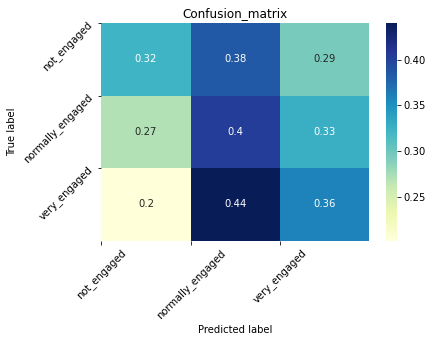

|stackedLSTM|
 Error rate = 0.6281179138321995 
 MSE =  1.145124716553288 
 Accuracy =  0.37188208616780044


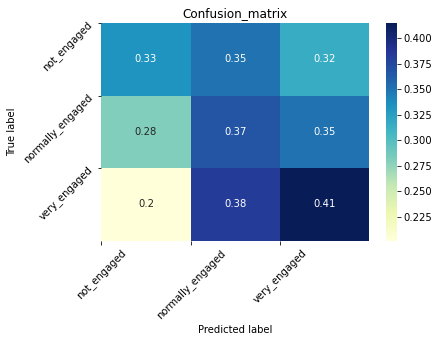

|biLSTM|
 Error rate = 0.6160241874527589 
 MSE =  1.1421012849584278 
 Accuracy =  0.3839758125472411


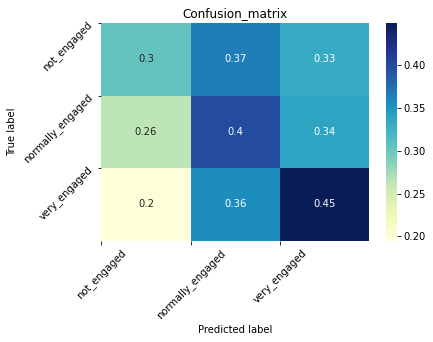

|bilstm_en|
 Error rate = 0.6621315192743764 
 MSE =  1.1859410430839001 
 Accuracy =  0.3378684807256236


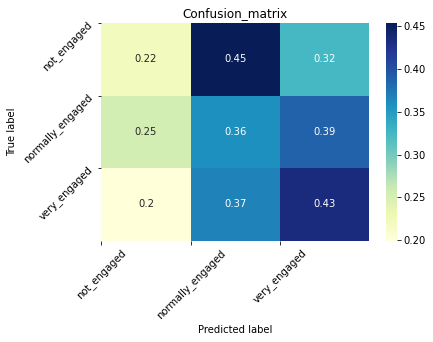

In [54]:
plot_conf_matrix(vanilaLSTM_model)
plot_conf_matrix(stackedLSTM_model)
plot_conf_matrix(biLSTM_model)
plot_conf_matrix(bilstm_en_model)

# 0. Prepare the averaged data
## Averaged features of each video file and add the label

In [ ]:
path = ('C:/Users/hasegawa-lab-pc/OneDrive - Japan Advanced Institute of Science and Technology/Documents/Dataset/DAiSEE/OpenFace_2.2.0_win_x64/processed/csv/')

df_feat = pd.read_csv(path+'csv_train/181374016.csv') #Load a feature sample
df_feat = df_feat.drop(df_feat.columns[0:5], axis=1) #take 1 every 21 frame   
print(df_feat)

# for num, col_name in enumerate(df_feat.columns):
#     print(num, col_name)

In [ ]:
df = df_feat.groupby(np.arange(len(df_feat))//30).mean()
print(df)

In [ ]:
#Average training data
feat_train = []
for noid, clipid in enumerate(df_train.ClipID):
    features = pd.read_csv('csv_train/'+clipid, index_col=None, header=0)
    features = features.drop(features.columns[0:5], axis=1)
    features = features.mean(axis=0)
    #add label in column
    label = df_train.Engagement[noid]
    features['Engagement'] = label
    features = pd.DataFrame(features).T #transpose after averaging
#     print(features)
    feat_train.append(features)
#     print(feat)
#     break
    
average_train = pd.concat(feat_train, axis=0, ignore_index=True)
average_train.to_csv('average_train.csv', header=True)
print(average_train)

In [ ]:
#Average validation data
feat_val = []
for noid, clipid in enumerate(df_val.ClipID):
    features = pd.read_csv('csv_val/'+clipid, index_col=None, header=0)
    features = features.drop(features.columns[0:5], axis=1)
    features = features.mean(axis=0)
    #add label in column
    label = df_val.Engagement[noid]
    features['Engagement'] = label
    features = pd.DataFrame(features).T #transpose after averaging
#     print(features)
    feat_val.append(features)
#     print(feat)
#     break
    
average_val = pd.concat(feat_val, axis=0, ignore_index=True)
average_val.to_csv('average_val.csv', header=True)
print(average_val)

In [ ]:
#Average test data
feat_test = []
for noid, clipid in enumerate(df_test.ClipID):
    features = pd.read_csv('csv_test/'+clipid, index_col=None, header=0)
    features = features.drop(features.columns[0:5], axis=1)
    features = features.mean(axis=0)
    #add label in column
    label = df_test.Engagement[noid]
    features['Engagement'] = label
    features = pd.DataFrame(features).T #transpose after averaging
#     print(features)
    feat_test.append(features)
#     features.append(features)
#     print(feat_test)
#     break
    
average_test = pd.concat(feat_test, axis=0, ignore_index=True)
# average_test.to_csv('average_test_trynew.csv', header=True)
print(average_test)

### test [1]

In [ ]:
test = pd.read_csv('csv_test/88265402700.csv', header=0)  
# ttest = pd.DataFrame()
test = test.drop(test.columns[0:5], axis=1)
test = test.mean(axis=0)
test['Engagement'] = 2
test = pd.DataFrame(test).T
# test.squeeze('columns')
# test.T
# ttest = pd.concat([ttest,test])
# print(test)

test2 = pd.read_csv('csv_test/88265402800.csv', header=0)
test2 = test2.drop(test2.columns[0:5], axis=1)
test2 = test2.mean(axis=0)
test2['Engagement'] = 2
test2 = pd.DataFrame(test2).T
# print(test2)

In [ ]:
li = pd.concat([test,test2])
print(li)

### test [2] (Prepare X (features) and Y (labels) for LSTM)

In [ ]:
test1 = pd.read_csv('10frames/10_88265402320.csv')
# test1 = np.array(test1)
label1 = np.array(2)
test2 = pd.read_csv('10frames/10_88265402330.csv')
# test2 = np.array(test2)
label2 = np.array(2)
# print(test1, test2)
print(test1.shape, label1, test2.shape, label2)
# print(df)
# tuplelist = [tuple(test1, test2) for test1, test2 in df.values]
tuplelist = [[test1,test2],[label1,label2]]
# print(tuplelist)

In [ ]:
x, y = tuplelist
x = np.array(x)
y = np.array(y)
print(x.shape, y.shape) #X.shape = [samples, timesteps, features]